In [1]:
import datetime
import numpy as np
from influxdb import InfluxDBClient

In [2]:
client = InfluxDBClient(host='140.112.42.158', port=8086, database='test_2')

In [3]:
CODE_TO_COUNTRY = {              # country language code to full language name  
        'zh-tw': 'Taiwan',
        'ko': 'Korean', 
        'ja': 'Japan',
        'es': 'Spanish',
        'fr': 'French',
        'ru': 'Russian',
        'west-us': 'West US',
        'US': 'United States',
        'SG': 'Singapore',
        'GB': 'Great Britain',
        'NL': 'Netherlands',
        'HK': 'Hong Kong'
    }

In [4]:
def build_query(t_s, t_e, channel=None, lang=None, loc=None):
    """
    gets all data from month/date to month/(date+1)
    t_s: time start
    t_e: time end 
    lang: stream language
    loc: client location 
    """
    channel = '/.*/' if channel is None else channel
    q = f"SELECT viewer, client_location, ip_list, fq_count, num_edge FROM {channel} WHERE time >= '{t_s}' AND time < '{t_e}'"
    if lang:
        q = f"{q} AND stream_language = '{lang}'"
    if loc:
        q = f"{q} AND client_location = '{loc}'"
    return q

def get_edge_num(result):
    tmp = list()
    transactions = 0
    for (stream, _), points in result.items():
        for point in points:
            edges = point['ip_list'].split(',')
            transactions += sum([int(fq) for fq in point['fq_count'].split(',')])
            for edge in edges:
                if edge not in tmp:
                    tmp.append(edge)
    return set(tmp), transactions

def mean(l):
    return sum(l)/len(l)

def TIMEFMT(t):
    return datetime.datetime.strptime(t, '%Y-%m-%dT%H:%M:%SZ')

#### Calculate gorund truth

In [5]:
START_T = '2019-11-01T10:00:00Z' # start time
END_T = '2019-11-01T11:00:00Z'   # end time
q = build_query(START_T, END_T, loc='tw', lang='zh-tw')
result = client.query(q)

ground_truth, _ = get_edge_num(result) # total # of edge servers

In [6]:
START_T = '2019-11-01T10:00:00Z' # start time
END_T = '2019-11-01T11:00:00Z'   # end time
q = build_query(START_T, END_T, loc='tw', lang='zh-tw')
result = client.query(q)

M, _ = get_edge_num(result) # number of edge servers in first capture

In [7]:
START_T = '2019-11-01T20:00:00Z' # start time
END_T = '2019-11-01T21:00:00Z'   # end time
q = build_query(START_T, END_T, loc='tw', lang='zh-tw')
result = client.query(q)

C, _ = get_edge_num(result) # number of edge servers in second capture

#### Calculate intersection of edge servers between two captures 

In [8]:
R = M.intersection(C)
print(len(R))

13


#### Estimate total number of servers by CRC: $N=\dfrac{MC}{R}$

In [9]:
N = (len(M)*len(C))//len(R)
print(N)

33


#### Input whole week data 

In [10]:
def get_estimation(date, date_1, t1, t2, loc, lang):
    st = f'2019-11-{date}T00:00:00Z' 
    et = f'2019-11-{date_1}T00:00:00Z'
    m_st = f'2019-11-{date}T08:00:00Z'
    m_et = f'2019-11-{date}T{t1}Z'
    c_st = f'2019-11-{date}T16:00:00Z'
    c_et = f'2019-11-{date}T{t2}Z'
    
    q = build_query(st, et, loc=loc, lang=lang)
    result = client.query(q)
    gt, gt_t = get_edge_num(result) 
    
    q = build_query(m_st, m_et, loc=loc, lang=lang)
    result = client.query(q)
    M, M_t = get_edge_num(result) 
    
    q = build_query(c_st, c_et, loc=loc, lang=lang)
    result = client.query(q)
    C, C_t = get_edge_num(result)
    
    R = M.intersection(C)
    
    try:
        N = len(M)*len(C)/len(R)
    except ZeroDivisionError:
        N = 0
    
    return int(N), len(gt), gt_t, (M_t+C_t)

In [11]:
date =   ['01', '02', '03', '04', '05', '07', '08', '09', '10', '11']
date_1 = ['02', '03', '04', '05', '06', '08', '09', '10', '11', '12']
time_1 = ['08:15:00', '08:30:00', '09:00:00', '10:00:00', '12:00:00', '14:00:00', '16:00:00']
time_2 = ['16:15:00', '16:30:00', '17:00:00', '18:00:00', '20:00:00', '22:00:00', '23:59:59']

In [12]:
gt = [40, 44, 46, 40, 66, 38, 40, 39, 38, 39]
est = [[], [], [], [], [], [], []]
trans = [[], [], [], [], [], [], []]
error = []
error_daily = [[], [], [], [], [], [], []]

for i, (t1, t2) in enumerate(zip(time_1, time_2)):
    err = 0
    for d, d1 in zip(date, date_1):
        N, gt, gt_t, t = get_estimation(d, d1, t1, t2, 'tw', None)
        print(N, gt, t, gt_t)
        
        est[i].append(N)
        trans[i].append(t)
        
        err += (N-gt)**2
        error_daily[i].append(N-gt)
    err = (err/10)**(1/2)
    print(err)
    error.append(err)

37 40 6396 325613
37 44 5602 301660
37 46 5326 280764
37 40 5852 328916
60 66 5511 310497
37 38 5041 241661
37 40 4854 169050
37 39 4619 217603
37 38 3931 229095
37 39 4953 169208
4.505552130427524
37 40 16022 325613
37 44 15731 301660
37 46 13874 280764
37 40 13982 328916
60 66 13540 310497
37 38 12004 241661
37 40 11729 169050
37 39 12504 217603
37 38 11339 229095
37 39 12277 169208
4.505552130427524
37 40 30416 325613
37 44 29630 301660
37 46 26755 280764
37 40 27304 328916
60 66 26014 310497
37 38 23110 241661
37 40 22960 169050
37 39 23128 217603
37 38 21580 229095
37 39 23853 169208
4.505552130427524
37 40 61744 325613
38 44 61492 301660
38 46 56953 280764
37 40 58640 328916
60 66 53940 310497
37 38 47619 241661
37 40 50149 169050
38 39 48090 217603
37 38 47817 229095
37 39 50685 169208
4.123105625617661
38 40 112861 325613
39 44 113196 301660
45 46 108001 280764
37 40 124907 328916
61 66 105324 310497
37 38 84572 241661
37 40 72209 169050
38 39 84683 217603
37 38 84264 229095
37

In [13]:
# import plotting related libraries
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
import matplotlib.patches as mpatches

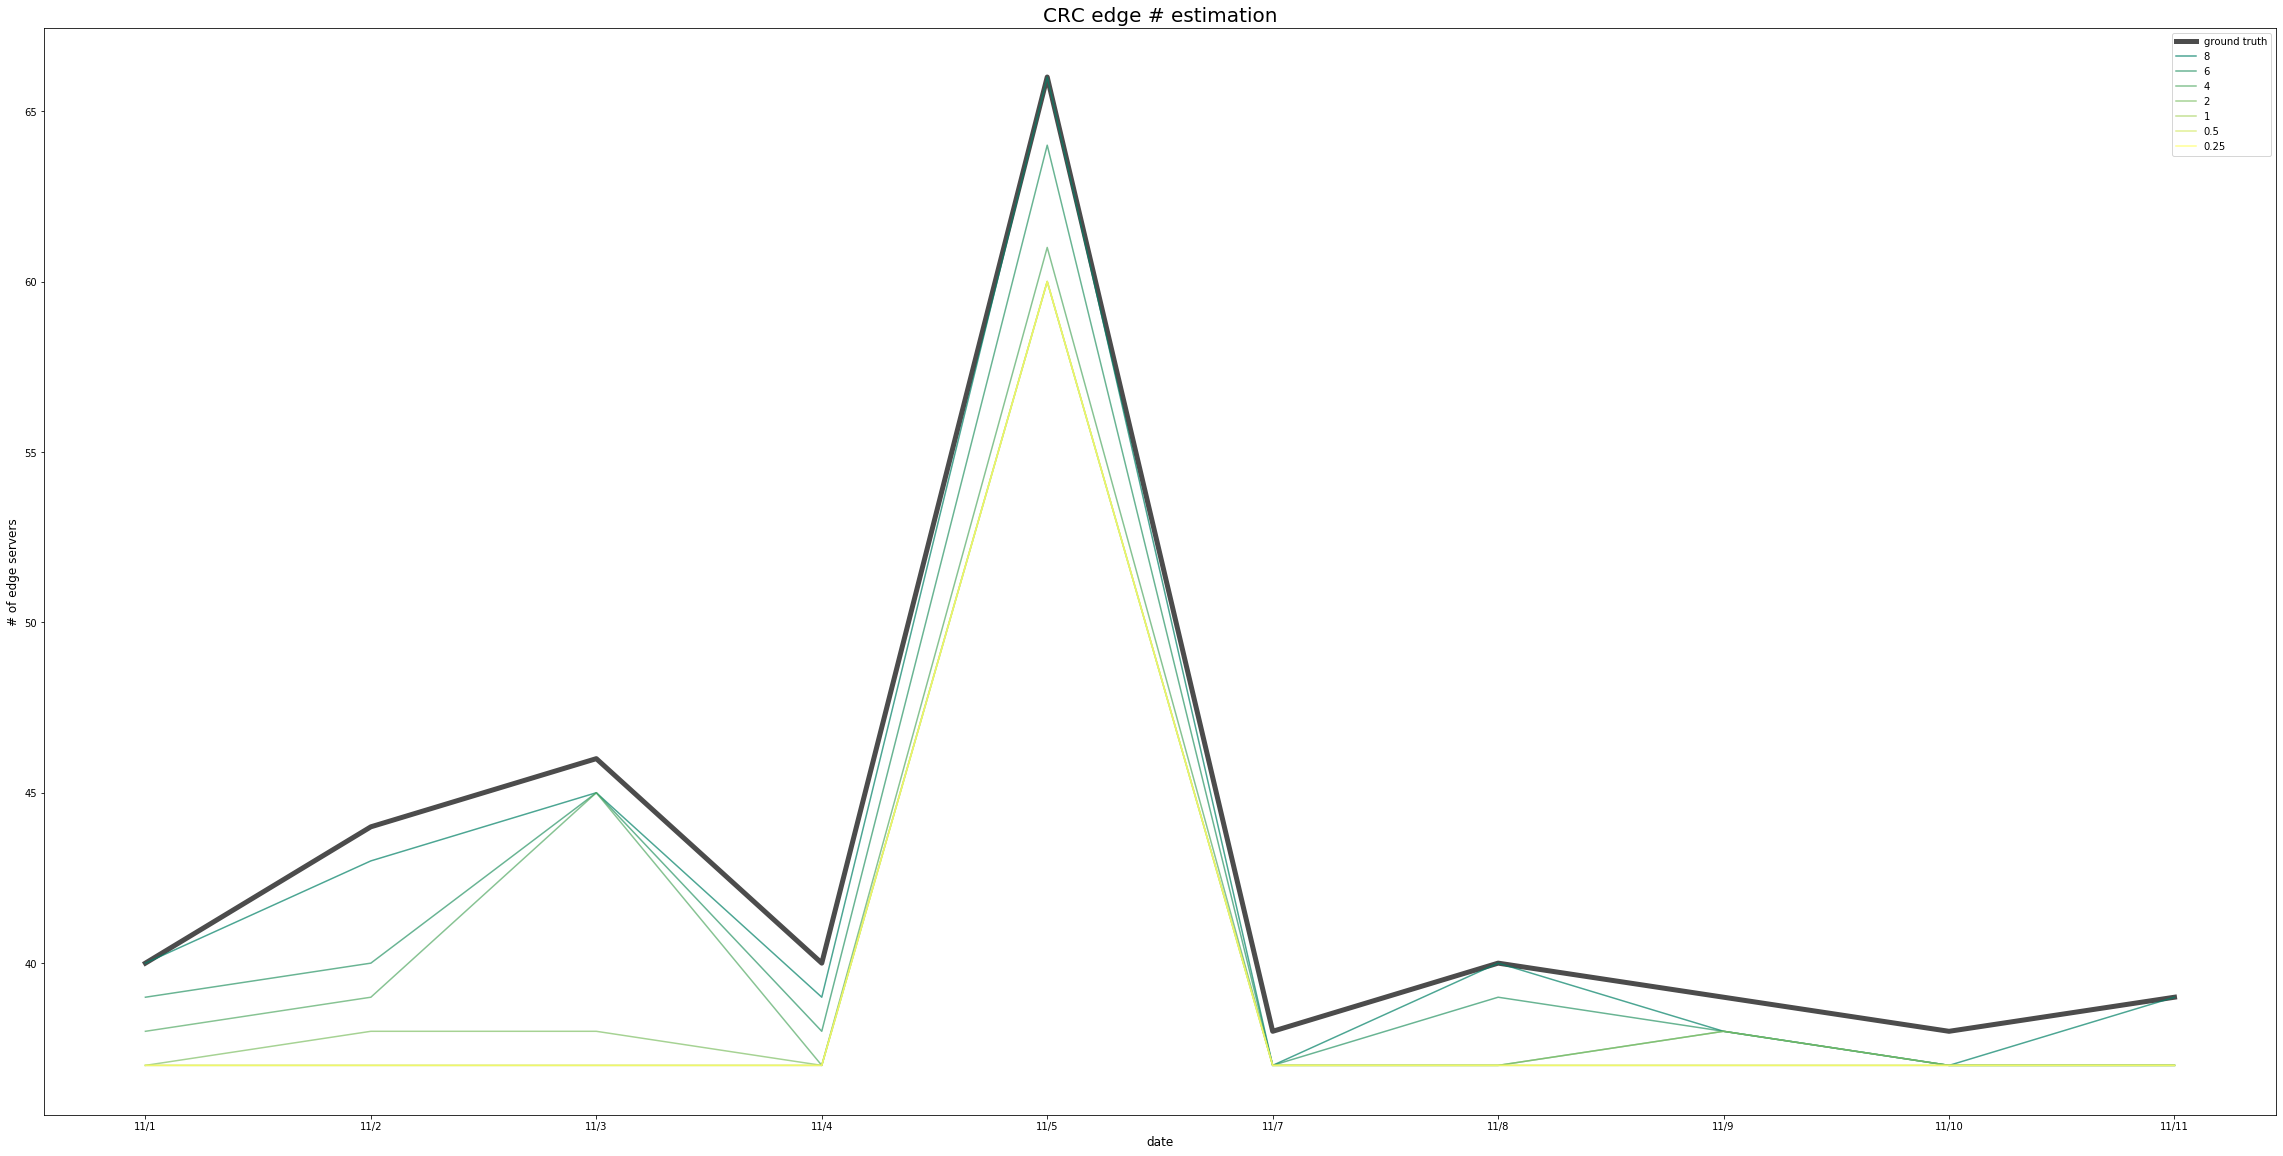

In [14]:
gt = [40, 44, 46, 40, 66, 38, 40, 39, 38, 39]
fig, ax = plt.subplots(figsize=(40, 20))
# x_axis = list(range(len(gt)))
x_axis = ['11/1','11/2', '11/3', '11/4', '11/5', '11/7', '11/8', '11/9', '11/10', '11/11']
labels = ['8', '6', '4', '2', '1', '0.5', '0.25']
ax.set_xlabel('date', fontsize=12)
ax.set_ylabel('# of edge servers', fontsize=12)

color_idx = np.linspace(0, 1, 7)
plt.plot(x_axis, gt, linewidth=5, color='black', label='ground truth', alpha=0.7)
for i, (c, e) in enumerate(zip(color_idx, est[::-1])):
    plt.plot(x_axis, e, color=plt.cm.summer(c), label=labels[i], alpha=0.7)
    
plt.title('CRC edge # estimation', fontsize=20)
plt.legend()
plt.show()


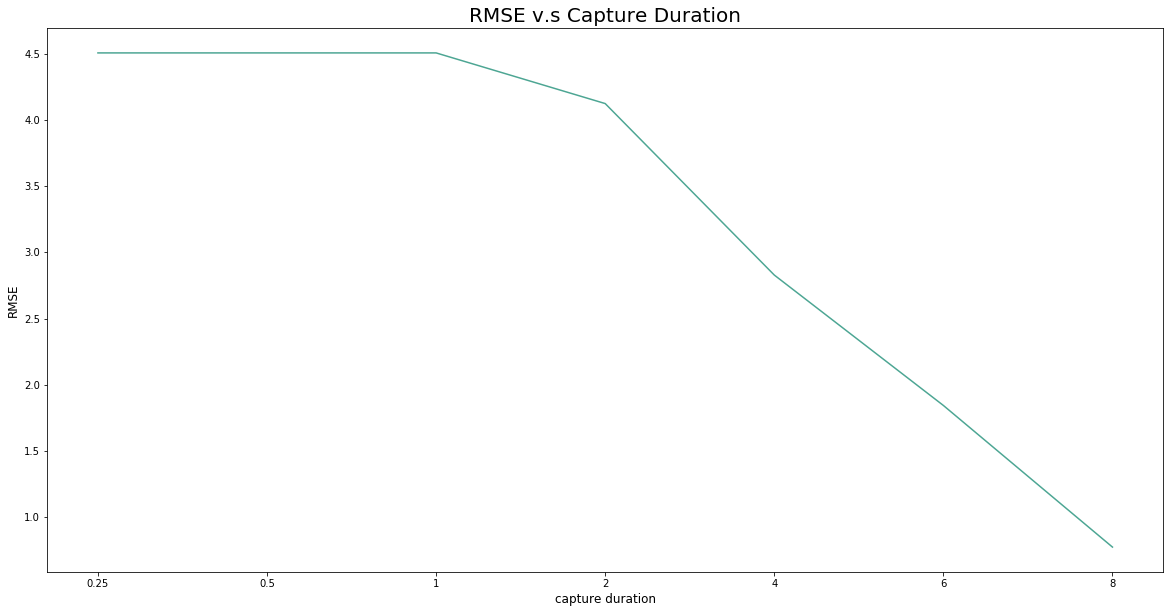

In [15]:
fig, ax = plt.subplots(figsize=(20, 10))
x_axis = ['0.25', '0.5', '1', '2', '4', '6', '8']

ax.set_xlabel('capture duration', fontsize=12)
ax.set_ylabel('RMSE', fontsize=12)

color_idx = np.linspace(0, 1, 7)
plt.plot(x_axis, error, color=plt.cm.summer(1), alpha=0.7)
plt.title('RMSE v.s Capture Duration', fontsize=20)

plt.show()

#### TODO: Plot # of reduction in transactions

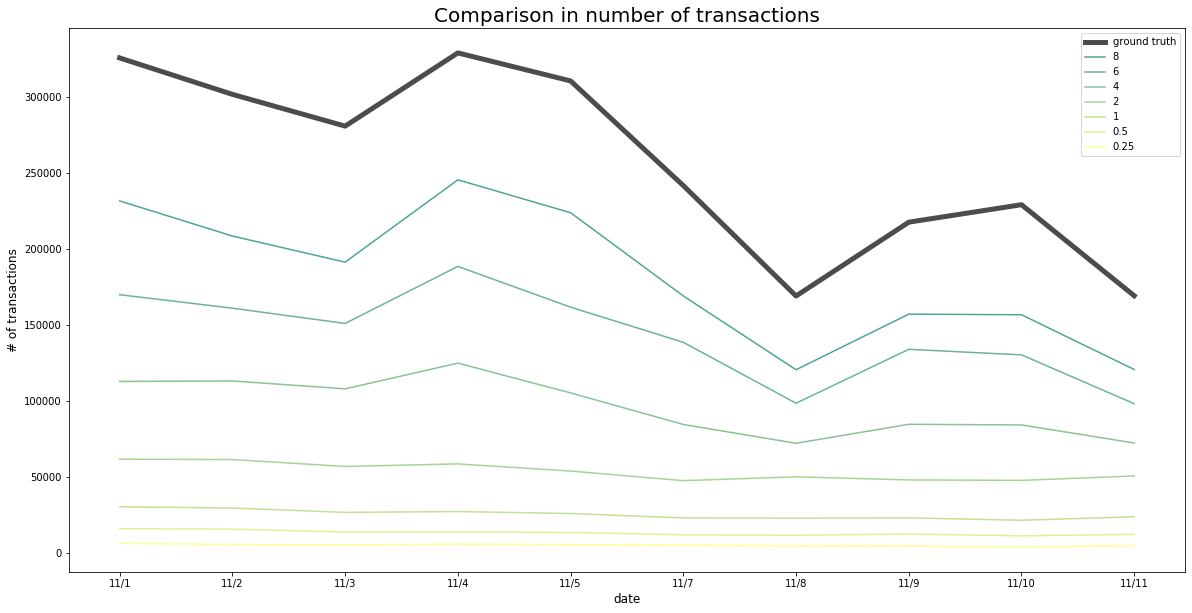

In [17]:
trans_gt = [325613, 301660, 280764, 328916, 310497, 241661, 169050, 217603, 229095, 169208]
fig, ax = plt.subplots(figsize=(20, 10))
x_axis = ['11/1','11/2', '11/3', '11/4', '11/5', '11/7', '11/8', '11/9', '11/10', '11/11']
labels = ['8', '6', '4', '2', '1', '0.5', '0.25']
ax.set_xlabel('date', fontsize=12)
ax.set_ylabel('# of transactions', fontsize=12)

color_idx = np.linspace(0, 1, 7)
plt.plot(x_axis, trans_gt, linewidth=5, color='black', label='ground truth', alpha=0.7)
for i, (c, e) in enumerate(zip(color_idx, trans[::-1])):
    plt.plot(x_axis, e, color=plt.cm.summer(c), label=labels[i], alpha=0.7)
    
plt.title('Comparison in number of transactions', fontsize=20)
plt.legend()
plt.show()

In [18]:
trans_date = list(zip(*trans))
per = [[round(t/gt, 3) for t in td] for (gt, td) in zip(trans_gt, trans_date)]
per = list(zip(*per)) 
print(per)

[(0.02, 0.019, 0.019, 0.018, 0.018, 0.021, 0.029, 0.021, 0.017, 0.029), (0.049, 0.052, 0.049, 0.043, 0.044, 0.05, 0.069, 0.057, 0.049, 0.073), (0.093, 0.098, 0.095, 0.083, 0.084, 0.096, 0.136, 0.106, 0.094, 0.141), (0.19, 0.204, 0.203, 0.178, 0.174, 0.197, 0.297, 0.221, 0.209, 0.3), (0.347, 0.375, 0.385, 0.38, 0.339, 0.35, 0.427, 0.389, 0.368, 0.428), (0.522, 0.534, 0.538, 0.573, 0.521, 0.574, 0.583, 0.616, 0.569, 0.581), (0.711, 0.691, 0.681, 0.746, 0.721, 0.7, 0.713, 0.722, 0.684, 0.713)]


#### Box plot of *error rate* and *reduction percentage*

In [19]:
error_daily = [tuple([abs(e)for e in err]) for err in error_daily]
error_daily_per = [[e/gt[i] for i, e in enumerate(err)] for err in error_daily]

In [20]:
print(per)
print(error_daily)
print(error_daily_per)

[(0.02, 0.019, 0.019, 0.018, 0.018, 0.021, 0.029, 0.021, 0.017, 0.029), (0.049, 0.052, 0.049, 0.043, 0.044, 0.05, 0.069, 0.057, 0.049, 0.073), (0.093, 0.098, 0.095, 0.083, 0.084, 0.096, 0.136, 0.106, 0.094, 0.141), (0.19, 0.204, 0.203, 0.178, 0.174, 0.197, 0.297, 0.221, 0.209, 0.3), (0.347, 0.375, 0.385, 0.38, 0.339, 0.35, 0.427, 0.389, 0.368, 0.428), (0.522, 0.534, 0.538, 0.573, 0.521, 0.574, 0.583, 0.616, 0.569, 0.581), (0.711, 0.691, 0.681, 0.746, 0.721, 0.7, 0.713, 0.722, 0.684, 0.713)]
[(3, 7, 9, 3, 6, 1, 3, 2, 1, 2), (3, 7, 9, 3, 6, 1, 3, 2, 1, 2), (3, 7, 9, 3, 6, 1, 3, 2, 1, 2), (3, 6, 8, 3, 6, 1, 3, 1, 1, 2), (2, 5, 1, 3, 5, 1, 3, 1, 1, 2), (1, 4, 1, 2, 2, 1, 1, 1, 1, 2), (0, 1, 1, 1, 0, 1, 0, 1, 1, 0)]
[[0.075, 0.1590909090909091, 0.1956521739130435, 0.075, 0.09090909090909091, 0.02631578947368421, 0.075, 0.05128205128205128, 0.02631578947368421, 0.05128205128205128], [0.075, 0.1590909090909091, 0.1956521739130435, 0.075, 0.09090909090909091, 0.02631578947368421, 0.075, 0.0512

In [21]:
per_mean = [100*mean(l) for l in per]
error_daily_mean = [mean(l) for l in error_daily]
error_daily_per_mean = [100*mean(l) for l in error_daily_per]

print(per_mean)
print(error_daily_mean)
print(error_daily_per_mean)

[2.11, 5.35, 10.26, 21.73, 37.879999999999995, 56.10999999999999, 70.82000000000001]
[3.7, 3.7, 3.7, 3.4, 2.4, 1.6, 0.6]
[8.258478554245144, 8.258478554245144, 8.258478554245144, 7.557404266214335, 5.406877256991675, 3.7250590751734918, 1.4773900775044941]


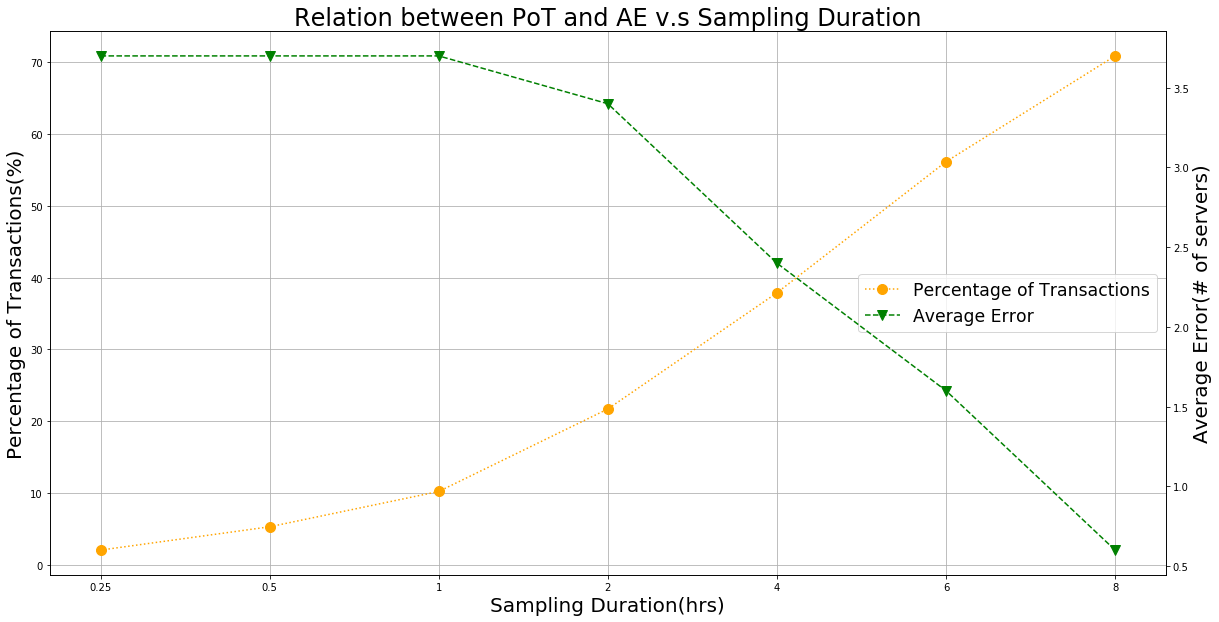

In [22]:
fig, ax1 = plt.subplots(figsize=(20, 10))
labels = ['0.25', '0.5', '1', '2', '4', '6', '8']

# mirror axis 
ax2 = ax1.twinx()

ln1 = ax1.plot(labels, per_mean, label='Percentage of Transactions', linestyle=':', color='orange', marker='o', markersize=10)
ln2 = ax2.plot(labels, error_daily_mean, label='Average Error', linestyle='--', color='green', marker='v', markersize=10)

# make labels appear in one legend
# https://stackoverflow.com/questions/5484922/secondary-axis-with-twinx-how-to-add-to-legend
lns = ln1+ln2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc='center right', fontsize = 'xx-large')

ax2.set_ylabel('Average Error(# of servers)', fontsize=20)
ax1.set_ylabel('Percentage of Transactions(%)', fontsize=20)
ax1.set_xlabel('Sampling Duration(hrs)', fontsize=20)
ax1.set_title('Relation between PoT and AE v.s Sampling Duration', fontsize=24)

ax1.grid()
plt.show()

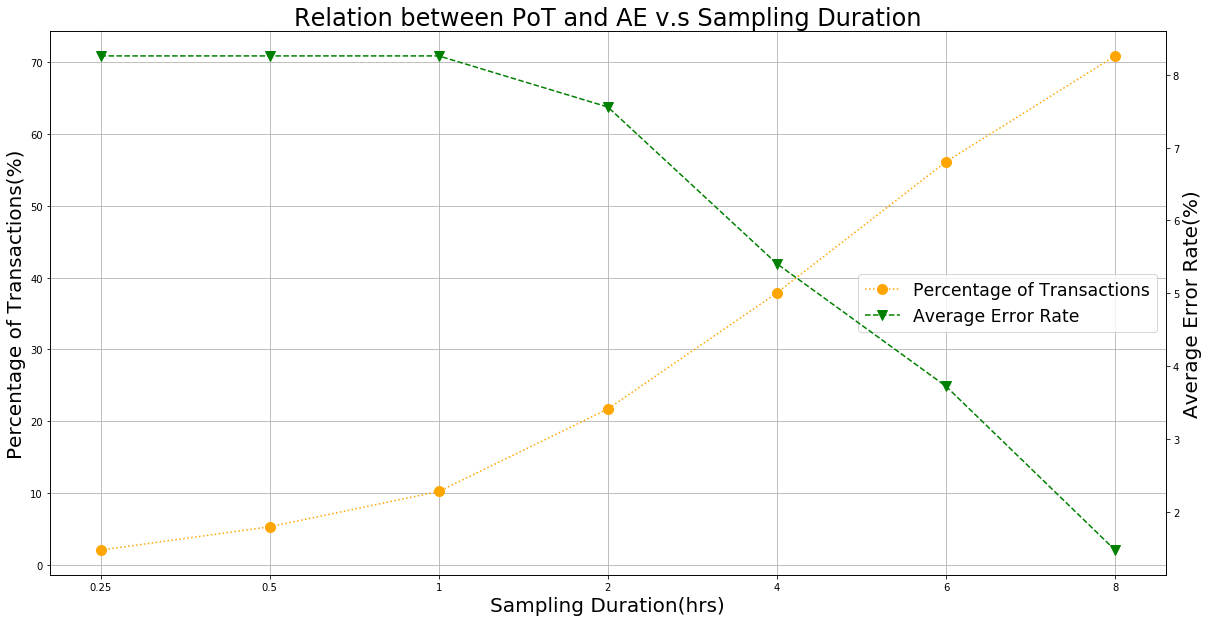

In [23]:
fig, ax1 = plt.subplots(figsize=(20, 10))
labels = ['0.25', '0.5', '1', '2', '4', '6', '8']

# mirror axis 
ax2 = ax1.twinx()

ln1 = ax1.plot(labels, per_mean, label='Percentage of Transactions', linestyle=':', color='orange', marker='o', markersize=10)
ln2 = ax2.plot(labels, error_daily_per_mean, label='Average Error Rate', linestyle='--', color='green', marker='v', markersize=10)

# make labels appear in one legend
# https://stackoverflow.com/questions/5484922/secondary-axis-with-twinx-how-to-add-to-legend
lns = ln1+ln2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc='center right', fontsize = 'xx-large')

ax2.set_ylabel('Average Error Rate(%)', fontsize=20)
ax1.set_ylabel('Percentage of Transactions(%)', fontsize=20)
ax1.set_xlabel('Sampling Duration(hrs)', fontsize=20)
ax1.set_title('Relation between PoT and AE v.s Sampling Duration', fontsize=24)

ax1.grid()
plt.show()

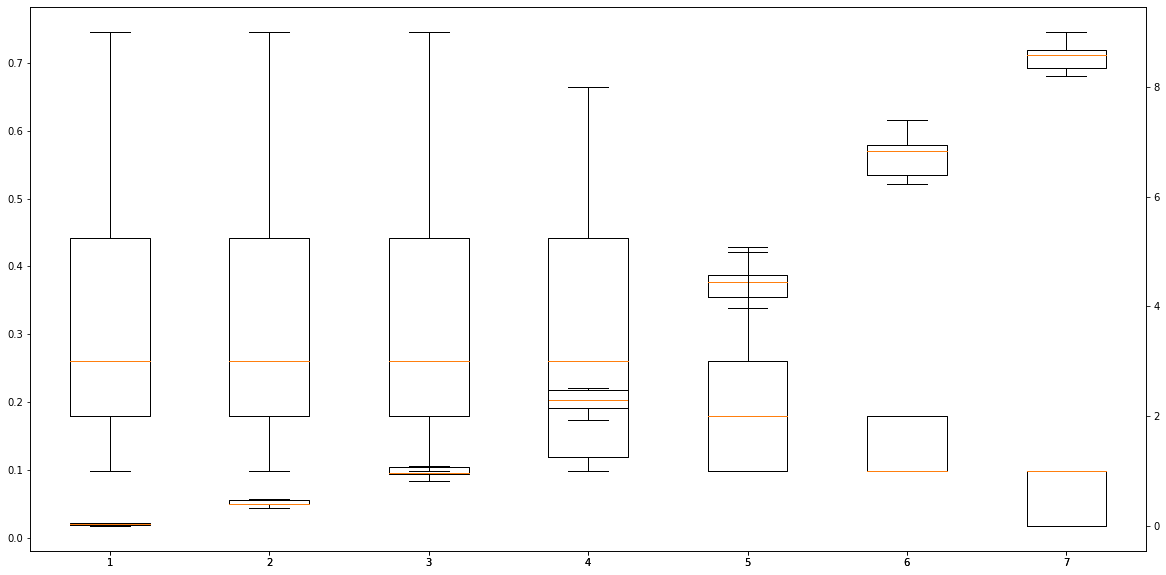

In [24]:
fig, ax1 = plt.subplots(figsize=(20, 10))
ax2 = ax1.twinx()

ax1.boxplot(per, 0, '')
ax2.boxplot(error_daily, 0, '')


plt.show()